# BMM via the changepoint kernel

## Author: Alexandra Semposki

### Date last edited: 02 December 2024

In [9]:
# do NOT rerun this cell if running greedy algorithm
new_pts = []

---
---


In [10]:
# first question!!! how many points??? a,b,c,d (no longer used)
#number = '0'
number = len(new_pts)
print(number)

0


---

In [11]:
# import needed packages
%load_ext autoreload
%autoreload 2

import sys
import arviz as az
sys.path.append('../src/')
import scipy as sp
from scipy.linalg import block_diag
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise
from custom_kernels import Changepoint
from eos_utils import *
from tov_utils import *
from scripts import *
from pqcd_reworked import PQCD

import sys
sys.path.append('../../../TOV_Solver')
from TOV_class import TOVsolver

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

# color plotting assistance
orders = [0, 1, 2, 3]
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## Setting up the training data <a id="setup"></a>

Load in the data sets from $\chi$EFT and perturbative QCD.

In [12]:
data_xeft = np.load('../data/NSM_data/chiral_nsm_scaled.npz')
data_pqcd = np.load('../data/eos_data/pressure_pqcd_data_scaled_NSM.npz')

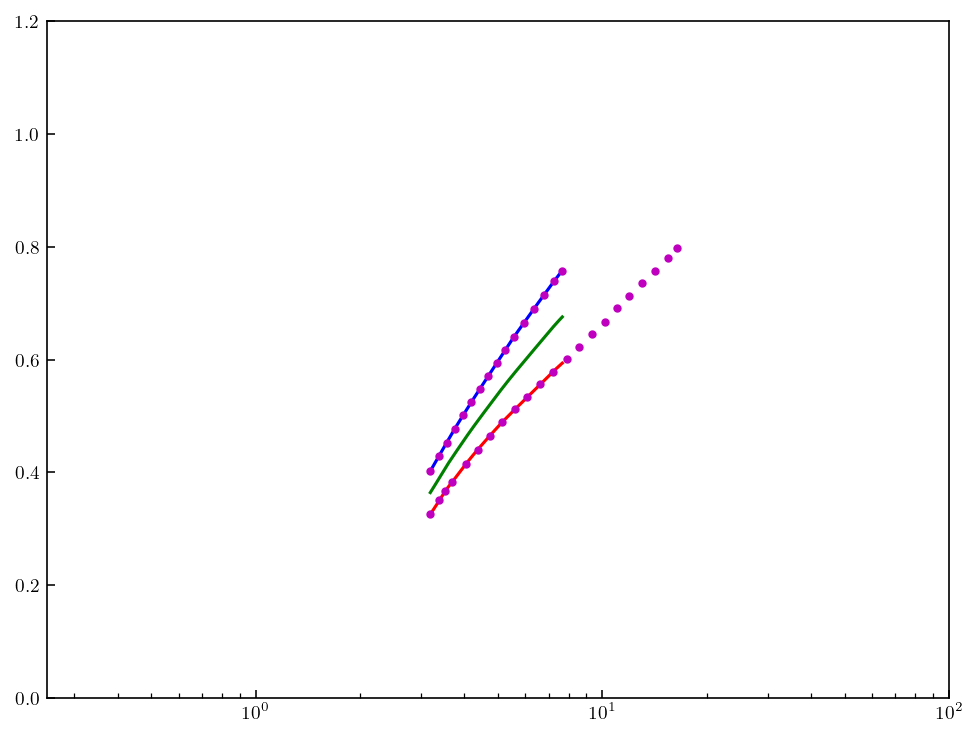

In [13]:
# also load fRG and scale "appropriately" and screw with it
df_frg = pd.read_csv('../data/frg_data_pressure.csv')
frg_anm = {
    'dens': df_frg['n/n0'],
    'pressure': 0.94*df_frg['P/P_free']  # scaling the data for ANM
}

# cut the contour up to find mean value
uppercontour = interp1d(frg_anm['dens'][22:], frg_anm['pressure'][22:], kind='cubic', fill_value='extrapolate')
lowercontour = interp1d(frg_anm['dens'][:22], frg_anm['pressure'][:22], kind='cubic', fill_value='extrapolate')

# solve at needed points below 
new_grid = np.linspace(min(frg_anm['dens'][22:]), max(frg_anm['dens'][22:]), 1000)
uppercontourgrid = uppercontour(new_grid)
lowercontourgrid = lowercontour(new_grid)

# finding mean line within the contour (easiest to use for more points, can draw random ones later)
mean_vals = np.zeros(len(new_grid))
std_vals = np.zeros(len(new_grid))
for i in range(len(new_grid)):
    mean_vals[i] = (lowercontourgrid[i] + uppercontourgrid[i])/2.0
    std_vals[i] = (uppercontourgrid[i]-lowercontourgrid[i])/2.0

plt.plot(df_frg['n/n0'], 0.94*df_frg['P/P_free'], color='m', marker='.', linestyle=' ', \
           zorder=10, label='Leonhardt et al. (2020)')
plt.plot(new_grid, mean_vals, 'g')
plt.plot(new_grid, uppercontourgrid, 'b')
plt.plot(new_grid, lowercontourgrid, 'r')
plt.xscale('log')
plt.ylim(0.0, 1.2)
plt.xlim(0.25, 100.0)

# discretize this to make it not 100 points
frg_data = {
    'dens': new_grid[10::28],
    'mean': mean_vals[10::28],
    'std': std_vals[10::28],
    'cov': np.diag(np.square(std_vals[10::28]))
}

In [14]:
# select training points to use 
data_xeft_2 = {
    'density': data_xeft['density'][::2],
    'mean': data_xeft['mean'][::2],
    'std_dev': data_xeft['std_dev'][::2],
    'cov': data_xeft['cov'][::2,::2]
    
}

cutoff = 20
chiral_tr_data, pqcd_tr_data, training_data_new = gp_data(data_xeft_2, data_pqcd, cutoff, \
                                                          all_orders=False, matter='ANM')

# adding some fake fRG data for funsies
n_frg = np.array([1.148]) #, 1.64])
p_mean_frg = np.array([0.8]) #, 0.85])
p_std_frg = np.array([0.05]) #, 0.05])
p_cov_frg = np.array([0.0025]) #, 0.00125], [0.00125, 0.0025]])  
# fake covariance data with 50% correlation or so

# delete some of the elements to keep some extra points
nope = [0, 4, 6]

# cut these out
chiral_data = {}
chiral_data['dens'] = np.delete(chiral_tr_data['dens'], [0,4,6], 0)
chiral_data['mean'] = np.delete(chiral_tr_data['mean'], [0,4,6], 0)
chiral_data['std'] = np.delete(chiral_tr_data['std'], [0,4,6], 0)
chiral_data['cov'] = np.delete(np.delete(chiral_tr_data['cov'], nope, 0), nope, 1)

# assign testing array (no equal points in training)
density_test = np.linspace(0.05, 16.4, 900)[:-1]

(8,) (8,) (8,) (8, 8)
(8,) (8,) (8,) (8, 8)
(5,) (5,) (5,) (5, 5)
Cov shape: (13, 13)


In [15]:
# make training data out of the first set
chiral_tr_final = {
    'dens': chiral_tr_data['dens'][1::2],
    'mean': chiral_tr_data['mean'][1::2],
    'std': chiral_tr_data['std'][1::2],
    'cov': chiral_tr_data['cov'][1::2,1::2]
}

# chiral_tr_final = {
#     'dens': chiral_data['dens'],
#     'mean': chiral_data['mean'],
#     'std': chiral_data['std'],
#     'cov': chiral_data['cov']
# }

In [16]:
pqcd_tr_final = {
    'dens': pqcd_tr_data['dens'],
    'mean': pqcd_tr_data['mean'],
    'std': pqcd_tr_data['std'],
    'cov': pqcd_tr_data['cov']
}

# if no mock data, use the original training set with no fRG data included
if len(new_pts) == 0:

    training_data_2 = {
        'dens': np.concatenate((chiral_tr_final['dens'], pqcd_tr_final['dens'])),
        'mean': np.concatenate((chiral_tr_final['mean'], pqcd_tr_final['mean'])),
        'std': np.concatenate((chiral_tr_final['std'], pqcd_tr_final['std'])),
        'cov': block_diag(chiral_tr_final['cov'], pqcd_tr_final['cov'])
    }
else:
    print('Using new data set from previous run.')
    training_data_2 = {
        'dens': np.concatenate((chiral_tr_final['dens'], new_pts, pqcd_tr_final['dens'])),
        'mean': np.concatenate((chiral_tr_final['mean'], frg_mean, pqcd_tr_final['mean'])),
        'std': np.concatenate((chiral_tr_final['std'], frg_std, pqcd_tr_final['std'])),
        'cov': block_diag(chiral_tr_final['cov'], frg_cov, pqcd_tr_final['cov'])
    }

# training_data_2 = {
#     'dens': np.concatenate((chiral_tr_final['dens'], n_frg, pqcd_tr_final['dens'])),
#     'mean': np.concatenate((chiral_tr_final['mean'], p_mean_frg, pqcd_tr_final['mean'])),
#     'std': np.concatenate((chiral_tr_final['std'], p_std_frg, pqcd_tr_final['std'])),
#     'cov': block_diag(chiral_tr_final['cov'], p_cov_frg, pqcd_tr_final['cov'])
# }

# initial greedy approach; no longer used

# 

if number == 'a':
    n_frg2 = np.array([frg_data['dens'][2]*0.164])
    p_mean_frg2 = np.array([frg_data['mean'][2]])
    p_std_frg2 = np.array([frg_data['std'][2]])
    p_cov_frg2 = np.array([frg_data['cov'][2,2]])
    
    training_data_2 = {
        'dens': np.concatenate((chiral_tr_final['dens'], n_frg2, pqcd_tr_final['dens'])),
        'mean': np.concatenate((chiral_tr_final['mean'], p_mean_frg2, pqcd_tr_final['mean'])),
        'std': np.concatenate((chiral_tr_final['std'], p_std_frg2, pqcd_tr_final['std'])),
        'cov': block_diag(chiral_tr_final['cov'], p_cov_frg2, pqcd_tr_final['cov'])
    }
elif number == 'b':
    n_frg = np.array([frg_data['dens'][0]*0.164])
    p_mean_frg = np.array([frg_data['mean'][0]])
    p_std_frg = np.array([frg_data['std'][0]])
    p_cov_frg = np.array([frg_data['cov'][0,0]])
    
    n_frg2 = np.array([frg_data['dens'][2]*0.164])
    p_mean_frg2 = np.array([frg_data['mean'][2]])
    p_std_frg2 = np.array([frg_data['std'][2]])
    p_cov_frg2 = np.array([frg_data['cov'][2,2]])
    
    training_data_2 = {
        'dens': np.concatenate((chiral_tr_final['dens'], n_frg, n_frg2, pqcd_tr_final['dens'])),
        'mean': np.concatenate((chiral_tr_final['mean'], p_mean_frg, p_mean_frg2, pqcd_tr_final['mean'])),
        'std': np.concatenate((chiral_tr_final['std'], p_std_frg, p_std_frg2, pqcd_tr_final['std'])),
        'cov': block_diag(chiral_tr_final['cov'], p_cov_frg, p_cov_frg2, pqcd_tr_final['cov'])
    }
elif number == 'c':
    n_frg = np.array([frg_data['dens'][0]*0.164])
    p_mean_frg = np.array([frg_data['mean'][0]])
    p_std_frg = np.array([frg_data['std'][0]])
    p_cov_frg = np.array([frg_data['cov'][0,0]])
    
    n_frg2 = np.array([frg_data['dens'][2]*0.164])
    p_mean_frg2 = np.array([frg_data['mean'][2]])
    p_std_frg2 = np.array([frg_data['std'][2]])
    p_cov_frg2 = np.array([frg_data['cov'][2,2]])
    
    n_frg3 = np.array([frg_data['dens'][3]*0.164])
    p_mean_frg3 = np.array([frg_data['mean'][3]])
    p_std_frg3 = np.array([frg_data['std'][3]])
    p_cov_frg3 = np.array([frg_data['cov'][3,3]])
    
    training_data_2 = {
        'dens': np.concatenate((chiral_tr_final['dens'], n_frg, n_frg2, n_frg3, pqcd_tr_final['dens'])),
        'mean': np.concatenate((chiral_tr_final['mean'], p_mean_frg, p_mean_frg2, p_mean_frg3, \
                                pqcd_tr_final['mean'])),
        'std': np.concatenate((chiral_tr_final['std'], p_std_frg, p_std_frg2, p_std_frg3, \
                               pqcd_tr_final['std'])),
        'cov': block_diag(chiral_tr_final['cov'], p_cov_frg, p_cov_frg2, p_cov_frg3, pqcd_tr_final['cov'])
    }
elif number == 'd':
    n_frg = np.array(frg_data['dens']*0.164)
    p_mean_frg = np.array(frg_data['mean'])
    p_std_frg = np.array(frg_data['std'])
    p_cov_frg = np.array(frg_data['cov'])
    
    training_data_2 = {
        'dens': np.concatenate((chiral_tr_final['dens'], n_frg, pqcd_tr_final['dens'])),
        'mean': np.concatenate((chiral_tr_final['mean'], p_mean_frg, pqcd_tr_final['mean'])),
        'std': np.concatenate((chiral_tr_final['std'], p_std_frg, pqcd_tr_final['std'])),
        'cov': block_diag(chiral_tr_final['cov'], p_cov_frg, pqcd_tr_final['cov'])
    }
elif number == 'none':
    training_data_2 = {
        'dens': np.concatenate((chiral_tr_final['dens'], pqcd_tr_final['dens'])),
        'mean': np.concatenate((chiral_tr_final['mean'], pqcd_tr_final['mean'])),
        'std': np.concatenate((chiral_tr_final['std'], pqcd_tr_final['std'])),
        'cov': block_diag(chiral_tr_final['cov'], pqcd_tr_final['cov'])
    }

# print training data for Table II results
print('\nDensity: \n', training_data_2['dens'])
print('\nMean: \n', training_data_2['mean'])
print('\nStd dev: \n', training_data_2['std'])
print('\nCov: \n', training_data_2['cov'])


Density: 
 [ 0.09357262  0.17103506  0.2484975   0.32595993  3.29816361  6.02771285
  8.7572621  11.48681135 14.2163606 ]

Mean: 
 [0.04384642 0.10521407 0.19189235 0.26642541 1.12216728 1.09799353
 1.08763023 1.08150343 1.07731912]

Std dev: 
 [0.00439573 0.01597702 0.03677041 0.07065512 0.03371912 0.02045932
 0.01580017 0.01333438 0.01177373]

Cov: 
 [[1.93224053e-05 6.39433820e-05 1.20853130e-04 1.82347847e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [6.39433820e-05 2.55265313e-04 5.55878240e-04 9.36888850e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.20853130e-04 5.55878240e-04 1.35206273e-03 2.49433392e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.82347847e-04 9.36888850e-04 2.49433392e-03 4.99214653e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.13697929e-

In [17]:
errorbar_kwargs_2 = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=3
)

In [18]:
# chiral EFT data 
n_xeft = data_xeft['density']
p_mean_xeft = data_xeft['mean']
p_stdv_xeft = data_xeft['std_dev']
p_cov_xeft = data_xeft['cov']

# get the pqcd curve to only plot greater than the cutoff choice
ind_cut = np.where(data_pqcd['density']/n0 >= cutoff)[0][0]

# pQCD data
n_pqcd = data_pqcd['density'][ind_cut:]
p_mean_pqcd = data_pqcd['mean'][ind_cut:, -1]
p_stdv_pqcd = data_pqcd['std_dev'][ind_cut:, -1]
p_cov_pqcd = data_pqcd['cov'][ind_cut:, ind_cut:, -1]

# save this for plotting later (uncomment to save)
#np.savez('../data/NSM_data/pressure_pqcd_cut_20_NSM.npz', dens=n_pqcd, mean=p_mean_pqcd, std=p_stdv_pqcd)

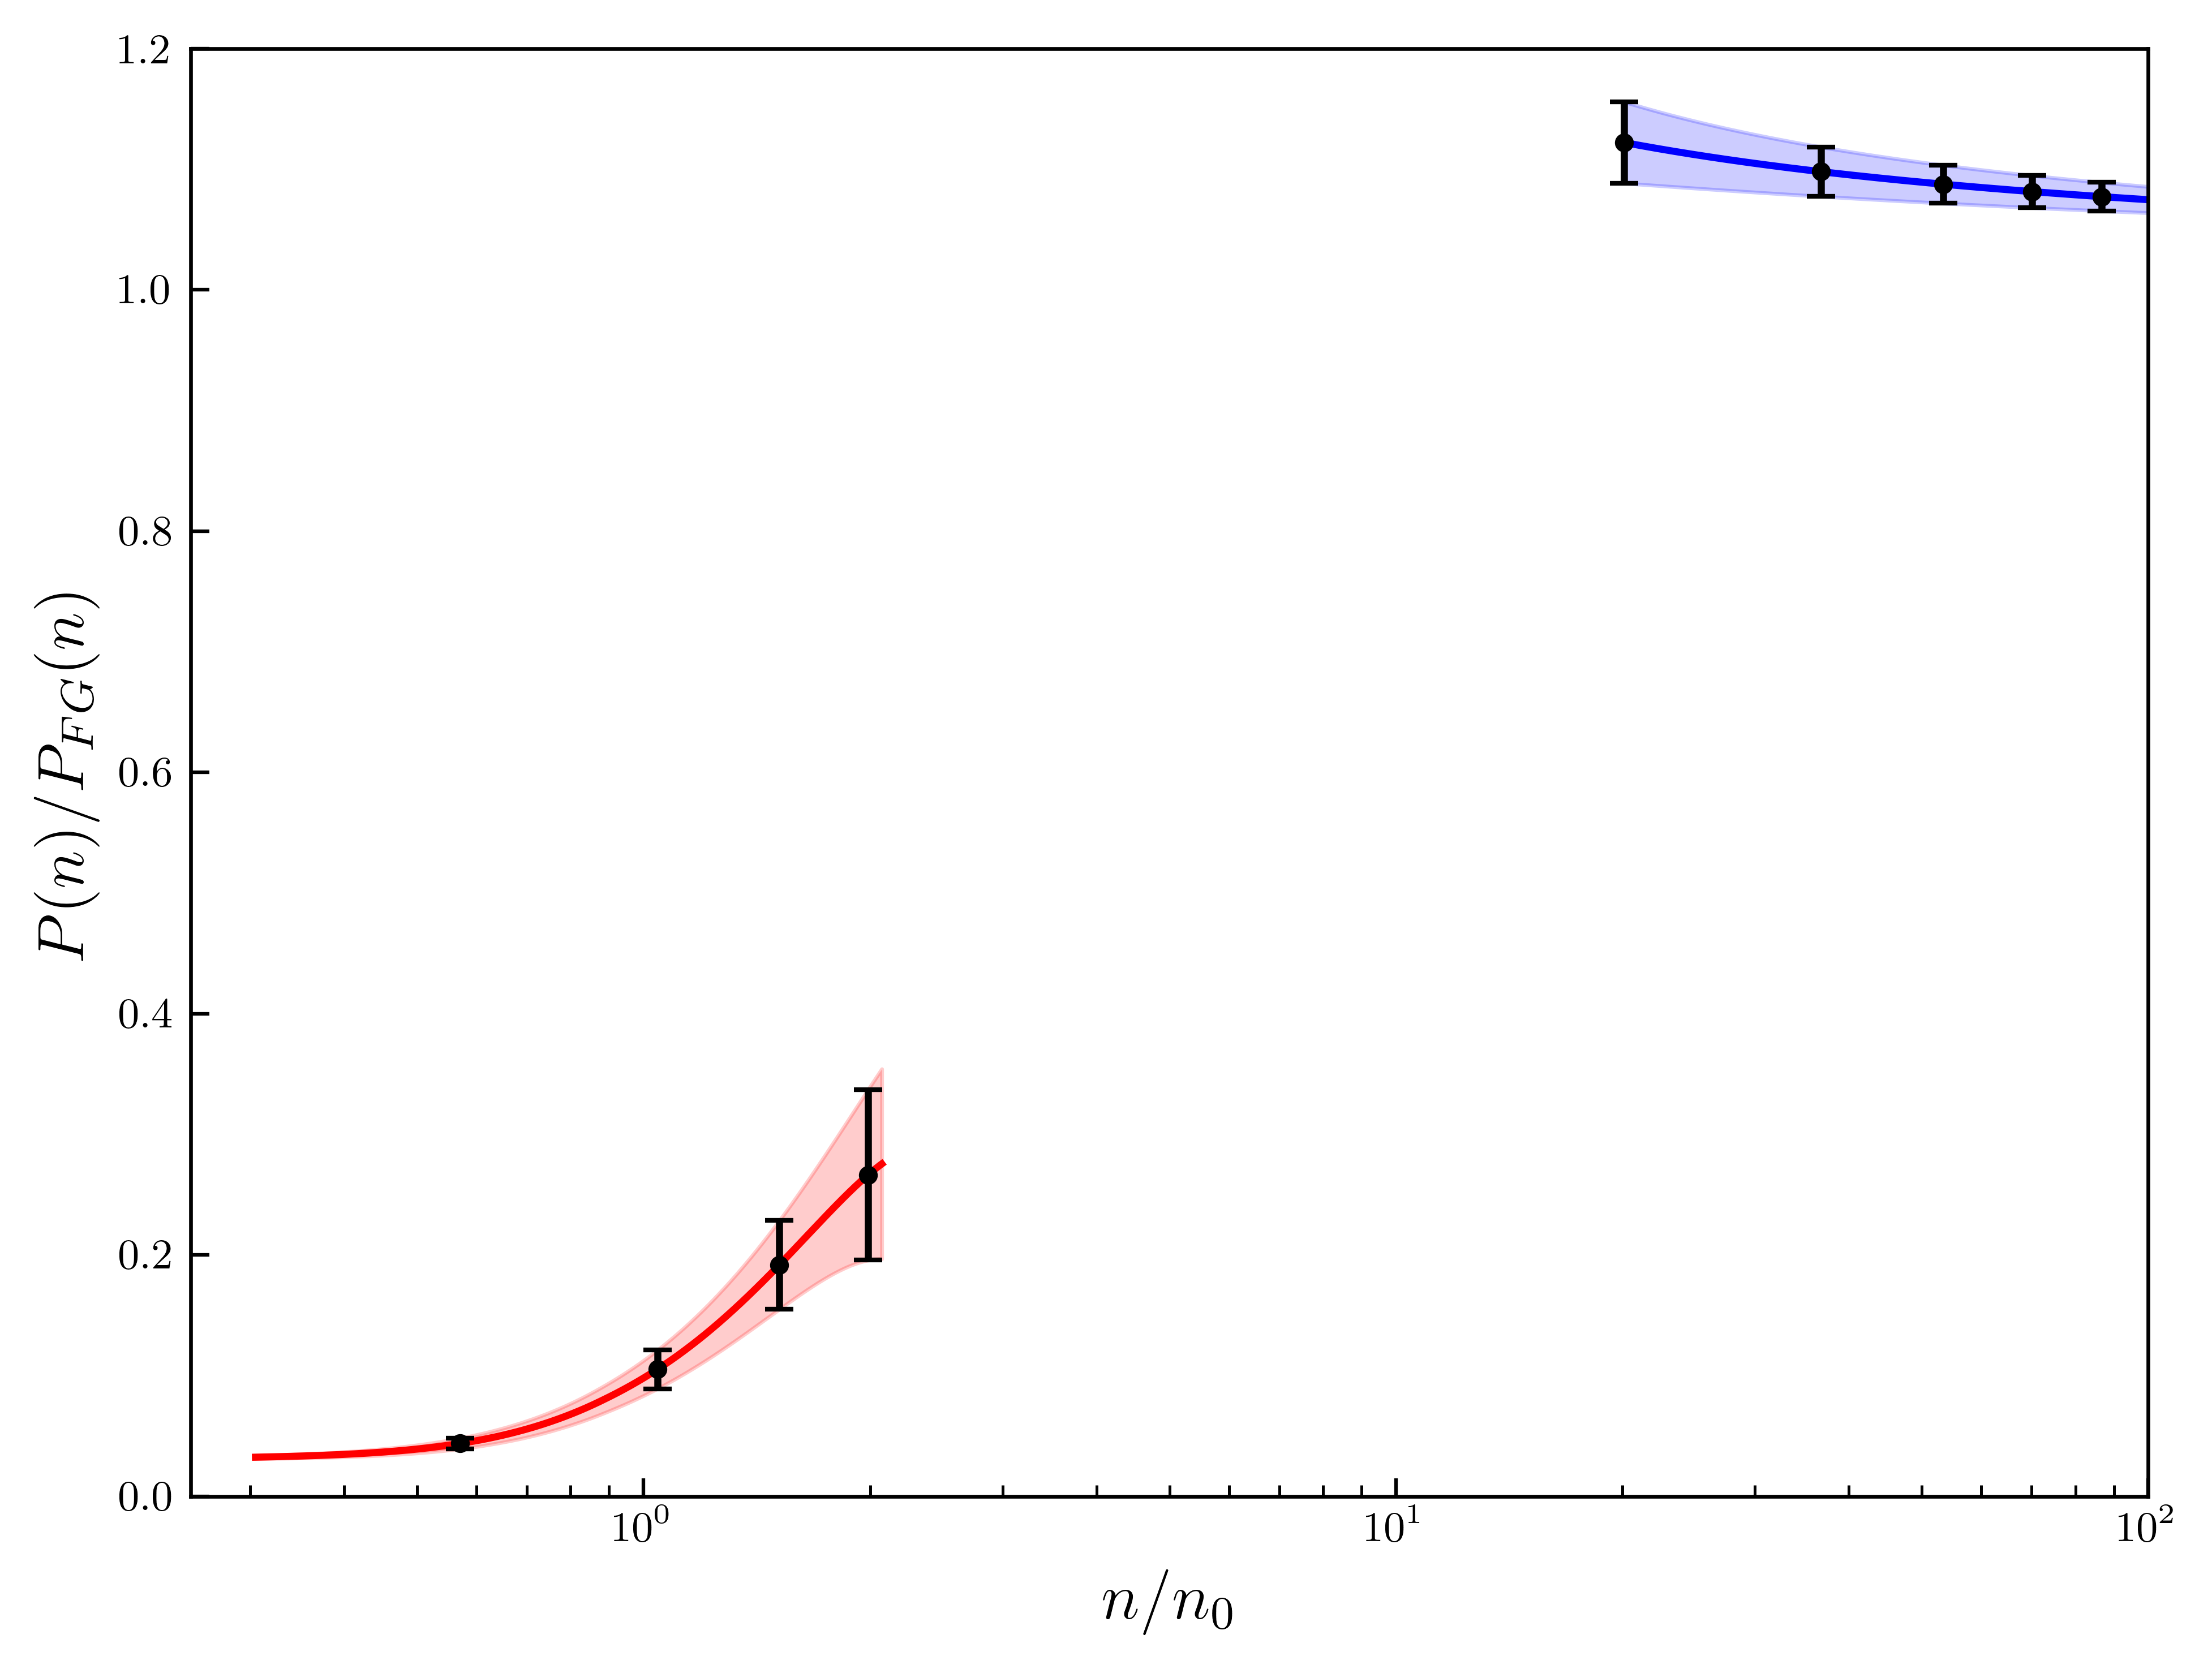

In [19]:
# plot the current data sets
fig, ax = plt.subplots(dpi=600)
ax: Axes
color_xeft = "red"
color_xeft_2 = 'green'
color_pqcd = "blue"
ax.set_xlim(0.25, 100.0)
ax.set_ylim(0, 1.2)
ax.set_xscale('log')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)

# result of idea 1
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)

ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)

# ax.plot(df_frg['n/n0'], 0.94*df_frg['P/P_free'], color='m', marker='.', linestyle=' ', \
#            zorder=10, label='Leonhardt et al. (2020)')

# new data for the fRG mock data contour
# ax.errorbar(x=n_frg/n0, y=p_mean_frg, yerr=p_std_frg, \
#             **errorbar_kwargs_2)

plt.show()

## Calculation of $P(n)$ using a changepoint kernel  <a id="calc_p_n"></a>

Now we construct the kernel we wish to use, which is the changepoint kernel. 

$$
k(x_i, x_j) = (1 - \sigma(x_i)) k_{1}(x_i,x_j) (1 - \sigma(x_j)) + \sigma(x_i) k_{2}(x_i, x_j) \sigma(x_j),
$$

where, for our initial test case, $k_{1}$, $k_{2}$ are the RBF kernel, and $\sigma$ are sigmoid functions, given as

$$
\sigma(x) = \frac{1}{1 + \exp(-k(x-x_{c})}.
$$ 


The changepoint is determined within the sigmoid function as $x_{c}$, along with a width parameter $k$ that will describe the slope of the function about the changepoint location. These are two parameters that will need to be optimized in the full training of the kernel---we will be attempting this after fixing them and testing that scenario first. The RBF kernels will both be trained on the individual data in each region, and let extrapolate until the changepoint.

This will first be coded manually and checked for accuracy, then will be coded into the `sklearn` workflow.

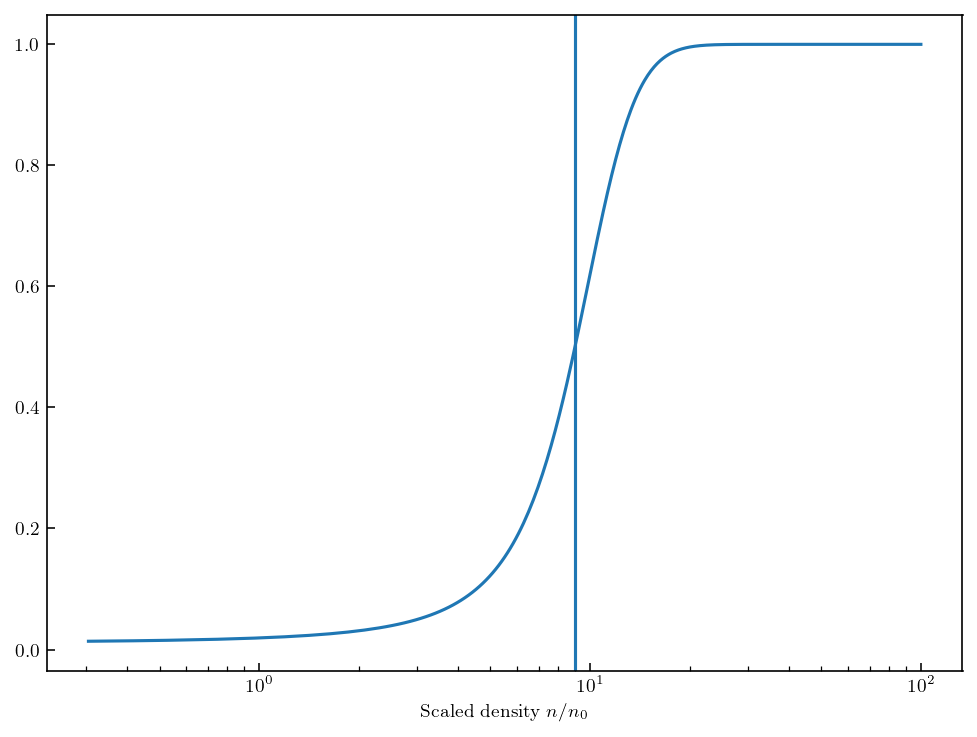

In [20]:
# set up the sigmoid function with selected changepoint and width (trial and error)
x_c = 1.476   # fm^-3 corresponding to 9*n0 for now

# want range over which sigmoid transitions---here, could be between 3*n0 and 15*n0, which gives
# 2.0 or so in total fm^-3. 
k_c = 3.0 

def sigmoid(dens, x0, k):
    return 1.0 / (1.0 + np.exp(-k*(dens-x0)))

# plot this, see what happens (looks good!)
plt.plot(density_test/n0, sigmoid(density_test, x_c, k_c))
plt.axvline(x=x_c/n0)
plt.xlabel(r'Scaled density $n/n_0$')
plt.xscale('log')
plt.show()

0.949**2 * RBF(length_scale=0.328)


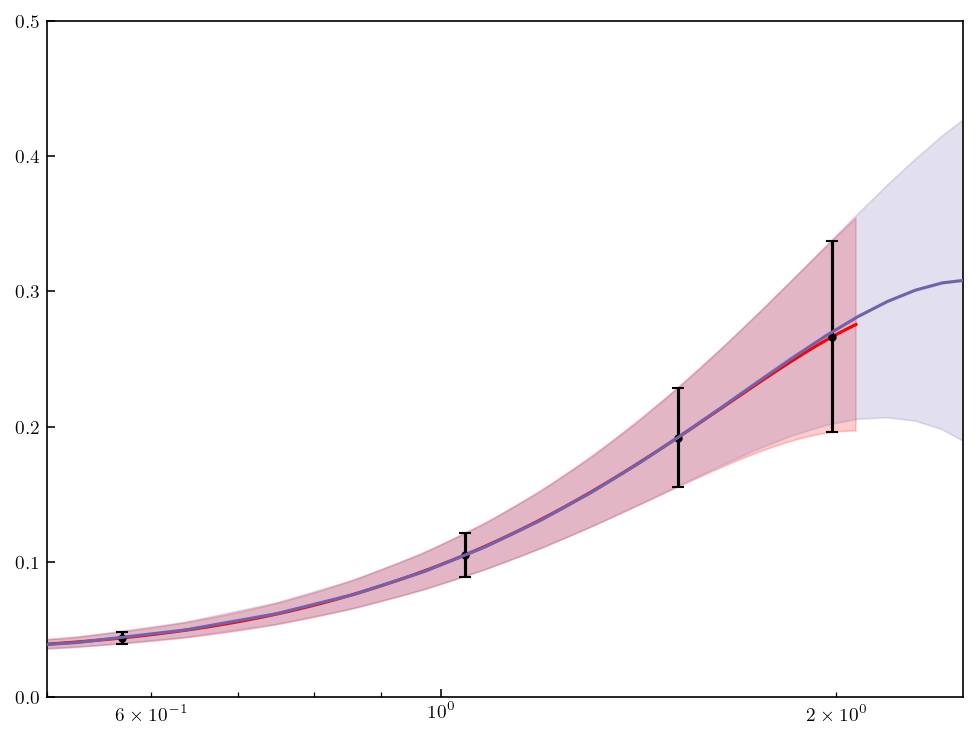

In [21]:
# trial and error optimal length scales and variances for now
k_chi = (C(constant_value=0.9, constant_value_bounds='fixed') \
         * RBF(length_scale=0.328, length_scale_bounds='fixed'))

# chiral EFT
gp = GaussianProcessRegressor2dNoise(
    kernel=k_chi,
    alpha = chiral_tr_final['cov'],
)

gp.fit(chiral_tr_final['dens'].reshape(-1,1), chiral_tr_final['mean'].reshape(-1,1))
print(gp.kernel_)
chi_predict, chi_std_predict = gp.predict(density_test.reshape(-1,1), return_std=True)
_, chi_cov_predict = gp.predict(density_test.reshape(-1,1), return_cov=True)
#print(chi_std_predict - np.sqrt(np.diag(chi_cov_predict)))  # stationary case, this works fine

# plot the result quickly to test
plt.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
plt.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft)
plt.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
plt.plot(density_test/n0, chi_predict, color=colors[2], zorder=10)
plt.fill_between(density_test/n0, chi_predict-chi_std_predict, chi_predict+chi_std_predict, \
                 color=colors[2], alpha=0.2)
plt.ylim(0.0, 0.5)
plt.xlim(0.5, 2.5)
plt.xscale('log')
plt.show()

# save that K matrix with alpha included to compare to changepoint kernel
Kalph_chi = np.array([[0.90001932, 0.87531221, 0.80512388, 0.70041324],
 [0.87531221, 0.90025527 ,0.87580415, 0.80593991],
 [0.80512388, 0.87580415, 0.90135206, 0.8777426 ],
 [0.70041324, 0.80593991 ,0.8777426,  0.90499215]])

In [22]:
# check standard deviation difference at 2*n0 or so
dens_band = n_xeft[-1]
std_band = p_stdv_xeft[-1]
ind_chi = np.where([density_test[i] > 0.34 for i in range(len(density_test))])[0][0]
gp_band = chi_std_predict[ind_chi]

print('% error at 2n0: ', round((std_band - gp_band)/std_band*100, 2))

% error at 2n0:  3.75


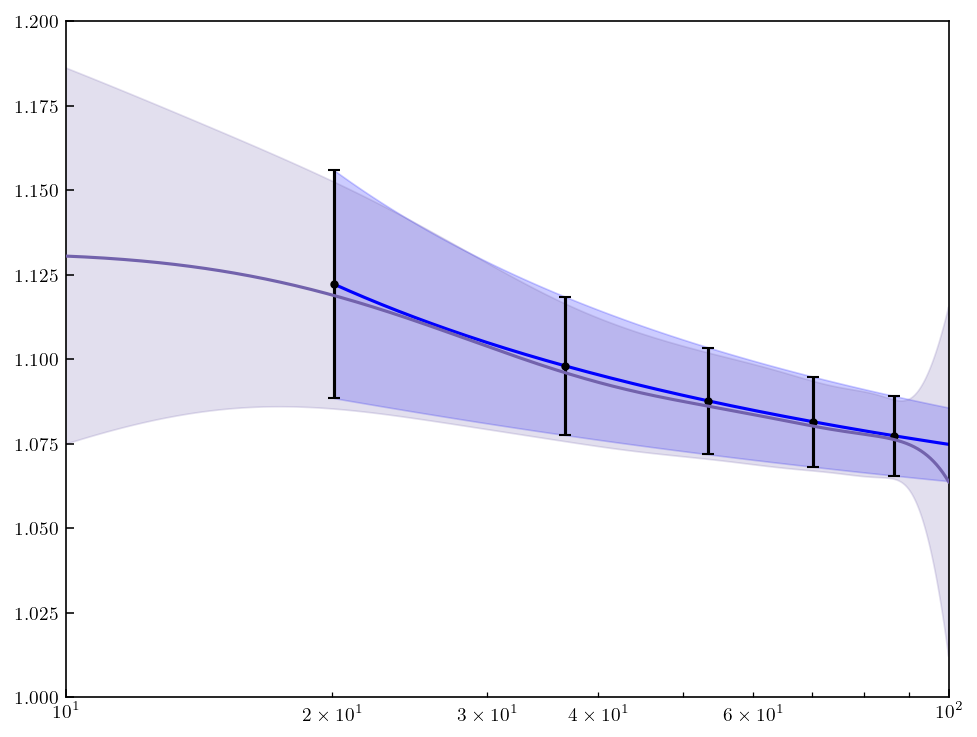

In [23]:
# now we're going to attempt to fit pQCD
k_pqcd = (C(constant_value=1.0, constant_value_bounds='fixed') \
          * RBF(length_scale=6.5, length_scale_bounds='fixed'))

# chiral EFT
gp2 = GaussianProcessRegressor2dNoise(
    kernel=k_pqcd,
    alpha = pqcd_tr_final['cov'],
)

gp2.fit(pqcd_tr_final['dens'].reshape(-1,1), pqcd_tr_final['mean'].reshape(-1,1), priors=False, \
        prior_choice='truncnorm_15')

pqcd_predict, pqcd_std_predict = gp2.predict(density_test.reshape(-1,1), return_std=True)
_, pqcd_cov_predict = gp2.predict(density_test.reshape(-1,1), return_cov=True)

#print(pqcd_std_predict - np.sqrt(np.diag(pqcd_cov_predict)))  # this works here too

# plot the result quickly to test
plt.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
plt.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
plt.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
plt.plot(density_test/n0, pqcd_predict, color=colors[2], zorder=10)
plt.fill_between(density_test/n0, pqcd_predict-pqcd_std_predict, pqcd_predict+pqcd_std_predict, \
                 color=colors[2], alpha=0.2)
plt.ylim(1.0, 1.2)
plt.xlim(10.0, 100.0)
plt.xscale('log')
plt.show()

# save K matrix with alpha for comparison
Kalph_pqcd = np.array([[1.00113698, 0.91629195, 0.70332744 ,0.45268407, 0.24435079],
 [0.91629195, 1.00041858 ,0.91592715, 0.70307084, 0.45247996]
, [0.70332744, 0.91592715, 1.00024965, 0.91581482 ,0.70298468],
 [0.45268407, 0.70307084, 0.91581482, 1.00017781 ,0.91576121],
 [0.24435079, 0.45247996, 0.70298468 ,0.91576121, 1.00013862]])

In [24]:
# check standard deviation difference at 2*n0 or so
dens_band = n_pqcd[0]
std_band = p_stdv_pqcd[0]
ind_pqcd = np.where([density_test[i] > 3.28 for i in range(len(density_test))])[0][0]
gp_band = pqcd_std_predict[ind_pqcd]

print('% error at 2n0: ', round((std_band - gp_band)/std_band*100, 2))

% error at 2n0:  0.19


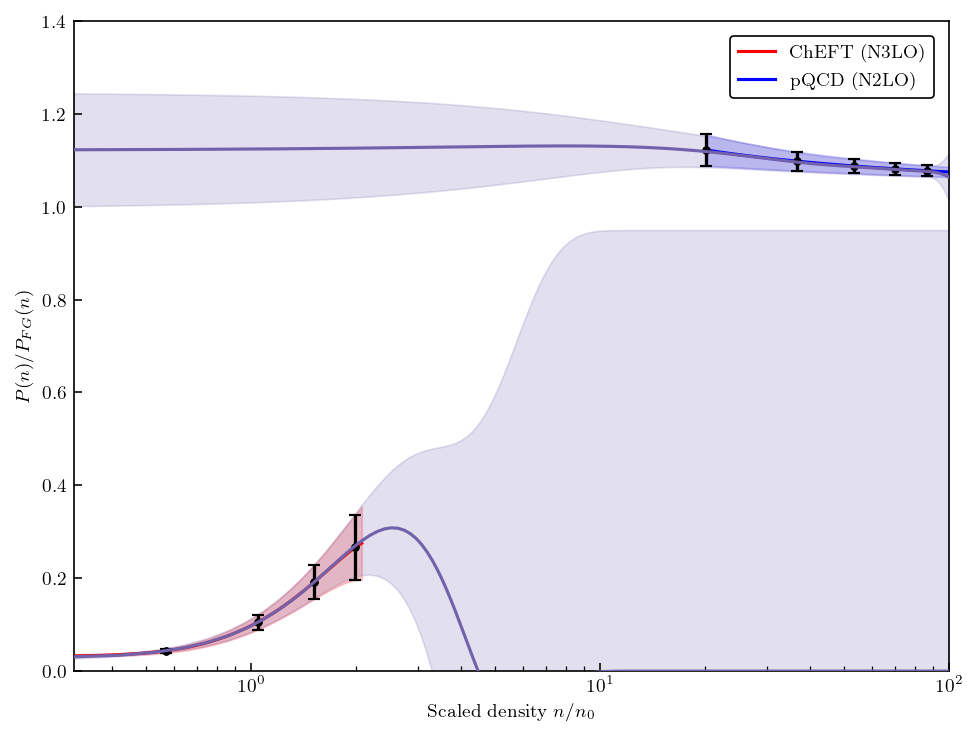

In [25]:
# check the plotting of both of these together, see what they look like
plt.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
plt.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft)
plt.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
plt.plot(density_test/n0, chi_predict, color=colors[2], zorder=10)
plt.fill_between(density_test/n0, chi_predict-chi_std_predict, chi_predict+chi_std_predict, \
                 color=colors[2], alpha=0.2)
plt.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
plt.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
plt.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
plt.plot(density_test/n0, pqcd_predict, color=colors[2], zorder=10)
plt.fill_between(density_test/n0, pqcd_predict-pqcd_std_predict, \
                 pqcd_predict+pqcd_std_predict, color=colors[2], alpha=0.2)
plt.ylim(0.0, 1.4)
plt.xlim(0.31, 100.0)
plt.xscale('log')
plt.legend()
plt.xlabel(r'Scaled density $n/n_0$')
plt.ylabel(r'$P(n)/P_{FG}(n)$')
plt.show()

Interesting that they never cross! This might mean we need a mean function to help the mixing along with a changepoint, I could see this being an issue later on.

### BMM using a changepoint kernel with a theta function

In [69]:
# we've implemented it in the kernel section, so let's try it out
from custom_kernels import Changepoint
kernel = Changepoint(ls1=0.328, ls2=6.5, cbar1=0.9, cbar2=1.0, changepoint=0.5, \
                     changepoint_bounds=[0.328,3.28], width=0.1, width_bounds=[0.05, 0.32])  # 1.476

# set up the GPR object
gpcp = GaussianProcessRegressor2dNoise(kernel=kernel, alpha=training_data_2['cov'] , 
                                       n_restarts_optimizer=10000)
print(cutoff)

20


In [70]:
# train the kernel (though we really don't need to, we need to fit)
X_train = training_data_2['dens'].reshape(-1,1)
y_train = training_data_2['mean'].reshape(-1,1)
gpcp.fit(X_train, y_train, priors=True, prior_choice='changepoint', cutoff=cutoff)
print(gpcp.kernel_)

/Users/alexandra/Documents/EOSBMM/buqeyenm/notebooks/../src/gp_utils.py:763: UserWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  warnings.warn(warning_msg) #ConvergenceWarning, stacklevel=2)  # commenting out for now (should investigate!)


Changepoint(changepoint=0.957, width=0.187)


Value of maximum likelihood changepoint: 0.9591591591591591
Value from the GP regression: 0.96


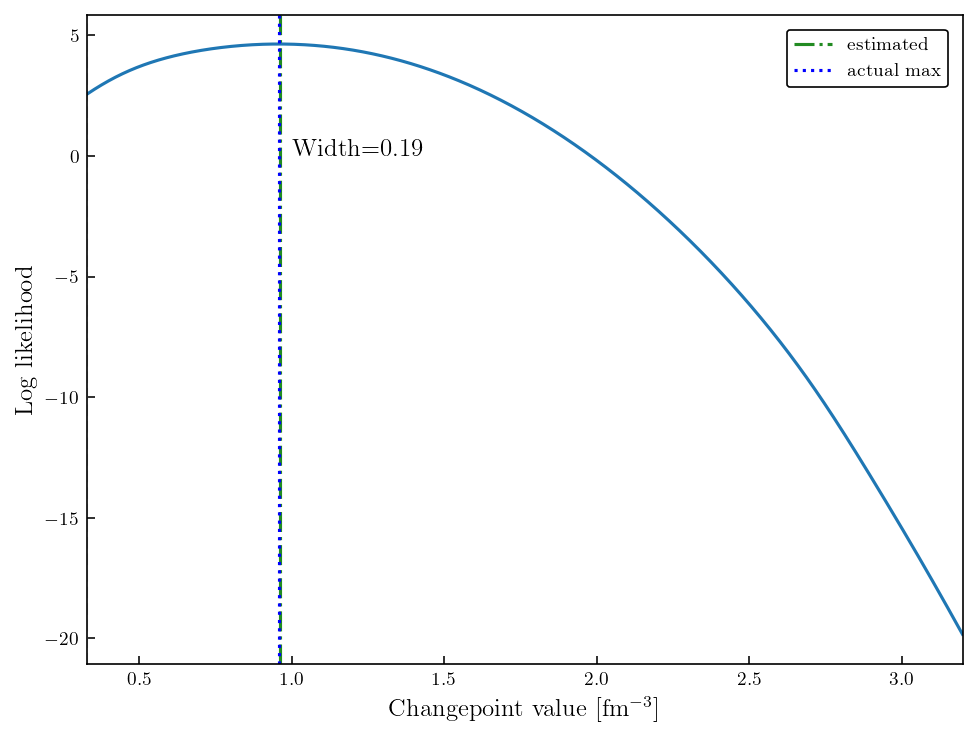

In [71]:
log_likelihood = []
test_cp = np.linspace(0.33, 3.2, 1000)
width= round(np.exp(gpcp.kernel_.theta[1]), 2)

for cp in test_cp:
    kernel = Changepoint(ls1=0.328, ls2=6.5, cbar1=0.9, cbar2=1.0, 
                     changepoint=cp, changepoint_bounds=[cp-0.001, cp+0.001], width=width, width_bounds='fixed')  
    # 1.476
    gpcptest = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_2['cov']  # here is where we input the full covariance matrix from the data
    )
    gpcptest.fit(X_train, y_train, priors=True, prior_choice='changepoint', cutoff=cutoff)
    log_likelihood.append(gpcptest.log_marginal_likelihood())
    
ind = np.where([np.asarray(log_likelihood[i]) >= max(log_likelihood) \
                for i in range(len(log_likelihood))])[0][-1]+1
cp_final = round(np.exp(gpcp.kernel_.theta[0]), 2)
w_final = round(np.exp(gpcp.kernel_.theta[1]), 2)

# print some values to check
print('Value of maximum likelihood changepoint: {}'.format(test_cp[ind]))
print('Value from the GP regression: {}'.format(cp_final))

#plt.xscale('log')
[plt.axvline(x=training_data_2['dens'][i], linestyle='dashed', color='lightgray') \
 for i in range(len(training_data_2['dens']))]
plt.axvline(x=cp_final, linestyle='-.', label='estimated', color='forestgreen')  
# plot the changepoint result
plt.plot(test_cp, log_likelihood)
plt.axvline(x=test_cp[ind], linestyle='dotted', label=r'actual max', color='blue')

# rest of plot
plt.xlabel(r'Changepoint value [fm$^{-3}$]', fontsize=12)
plt.xlim(0.328, 3.2)
plt.text(1.0, 0.0, 'Width={}'.format(width), fontsize=12)
plt.ylabel('Log likelihood', fontsize=12)
plt.legend()

In [75]:
log_likelihood = []
test_w = np.linspace(0.055, 0.315, 100)
chp = np.exp(gpcp.kernel_.theta[0])

for w in test_w:
    kernel = Changepoint(ls1=0.328, ls2=6.5, cbar1=0.9, cbar2=1.0, 
                     changepoint=chp, changepoint_bounds='fixed', width=w, \
                         width_bounds=[w-0.001, w+0.001])  # 1.476
    gpcptest2 = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_2['cov']  # here is where we input the full covariance matrix from the data
    )
    gpcptest2.fit(X_train, y_train, priors=True, prior_choice='changepoint', cutoff=cutoff)
    log_likelihood.append(gpcptest2.log_marginal_likelihood())
    
print(max(log_likelihood)*0.164)
ind = np.where([np.asarray(log_likelihood[i]) >= max(log_likelihood) \
                for i in range(len(log_likelihood))])[0][-1]
print('Value of width at maximum log likelihood:', test_w[ind])
cp_final = round(np.exp(gpcp.kernel_.theta[0]), 2)
w_final = round(np.exp(gpcp.kernel_.theta[1]), 2)
print(w_final)

plt.axvline(x=test_w[ind], linestyle='dashed', color='darkorange', alpha=0.3)
plt.axvline(x=w_final, linestyle='-.', color='forestgreen', alpha=0.3)   # plot the changepoint result
plt.plot(test_w, log_likelihood)
plt.xlabel(r'Width', fontsize=12)
plt.xlim(min(test_w), max(test_w))
plt.text(0.15, 4.55, 'Changepoint={}'.format(cp_final), fontsize=12)
plt.ylabel('Log likelihood', fontsize=12)

ValueError: failed in converting 7th argument `g' of _lbfgsb.setulb to C/Fortran array

In [76]:
# # comparing matrices
# Kalph_cp_chi = gpcp.Kalph[:4,:4]

# Kalph_cp_pqcd = gpcp.Kalph[4:,4:]

# ok everything here looks fine, 10^-9 should be OK
# print('Chiral EFT differences: \n', Kalph_cp_chi - Kalph_chi)
# print('\npQCD differences: \n', Kalph_cp_pqcd - Kalph_pqcd)

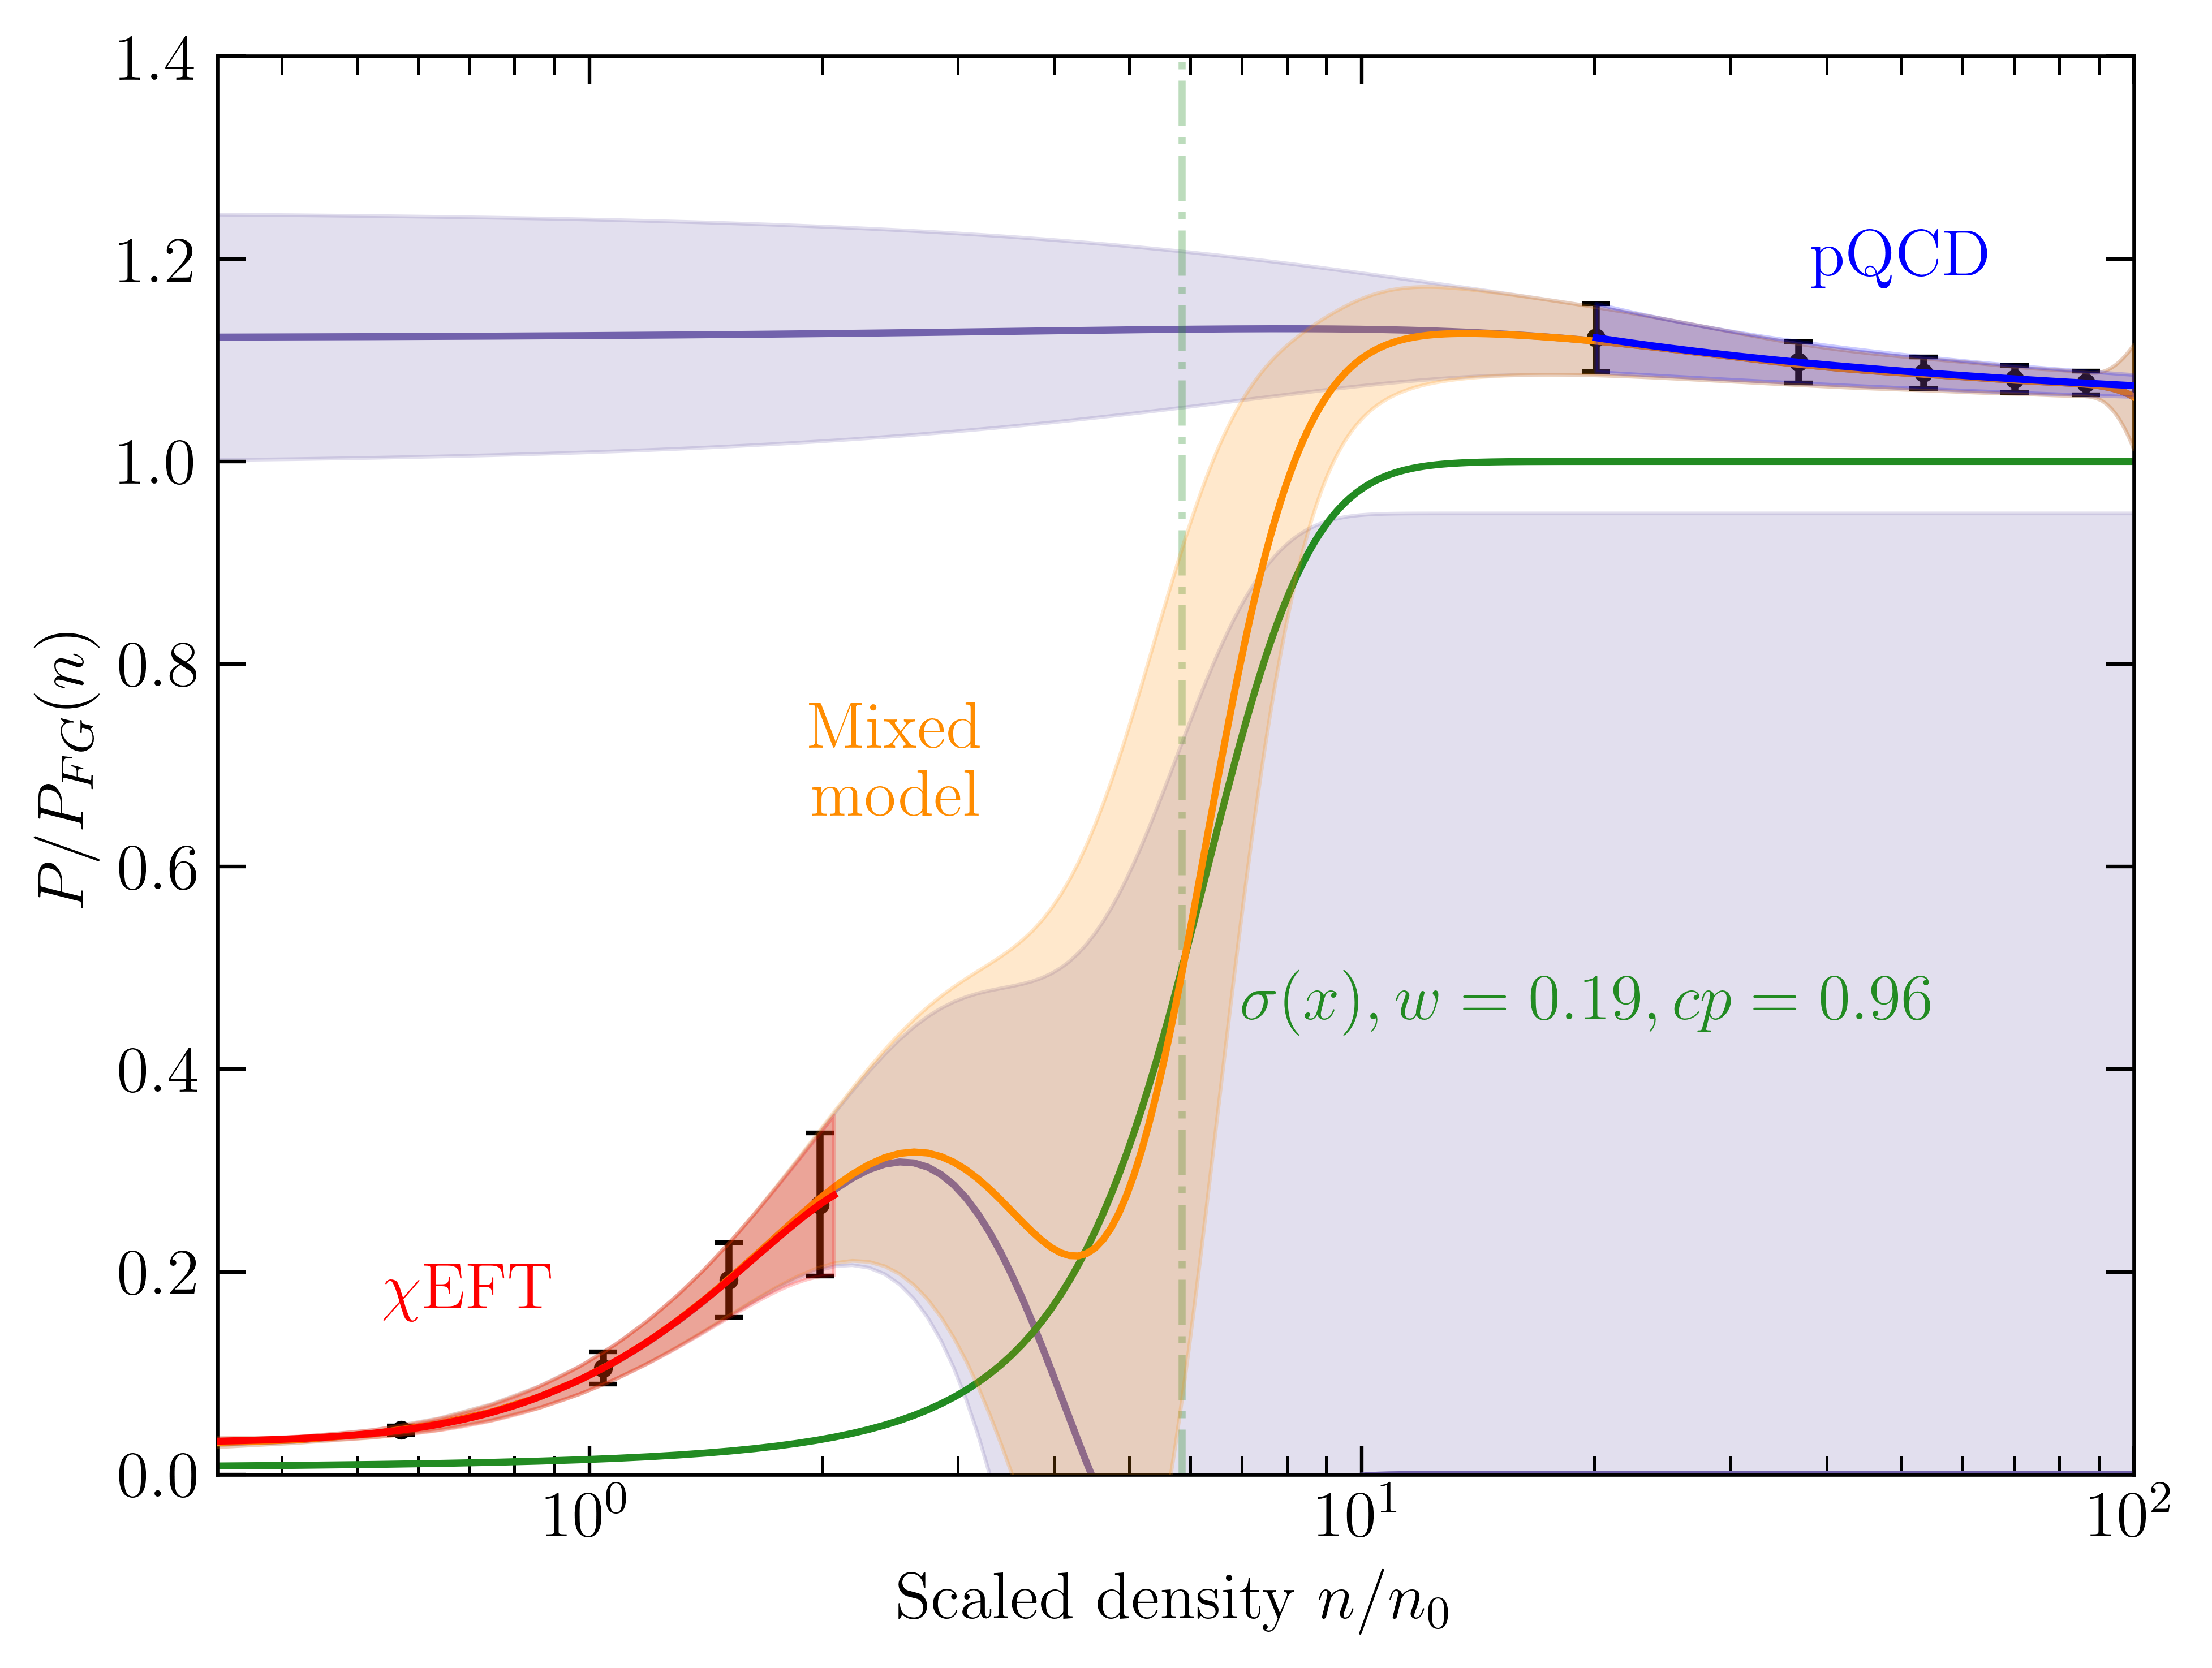

In [77]:
# try predicting with this kernel
X = density_test.reshape(-1,1)
y_pred_0, y_stdv_0 = gpcp.predict(X, return_std=True)  # this is not using the new params
y_pred_0, y_cov_0 = gpcp.predict(X, return_cov=True) 

# plot the result
fig, ax = plt.subplots(1,1, dpi=600)
# check the plotting of both of these together, see what they look like
ax.tick_params(which='major', labelsize=14, right=True, top=True, length=6)
ax.tick_params(which='minor', right=True, top=True, length=4)
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)', zorder=10)
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft, zorder=9)
ax.plot(density_test/n0, chi_predict, color=colors[2])
ax.fill_between(density_test/n0, chi_predict-chi_std_predict, chi_predict+chi_std_predict, \
                 color=colors[2], alpha=0.2)
ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)', zorder=10)
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd, \
                zorder=9)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
ax.plot(density_test/n0, pqcd_predict, color=colors[2])
ax.fill_between(density_test/n0, pqcd_predict-pqcd_std_predict, \
                 pqcd_predict+pqcd_std_predict, color=colors[2], alpha=0.2)
ax.plot(X[:,0]/n0, y_pred_0, color='darkorange', zorder=8)
ax.fill_between(X[:,0]/n0, y_pred_0-y_stdv_0, \
                 y_pred_0+y_stdv_0, alpha=0.2, color='darkorange', zorder=7)

# changepoint location
cp_final = round(np.exp(gpcp.kernel_.theta[0]), 2)
w_final = round(np.exp(gpcp.kernel_.theta[1]), 2)

# plot this
ax.plot(density_test/n0, (1.0 / (1.0 + np.exp(-(density_test-cp_final)/w_final))), color='forestgreen')
ax.text(7.0, 0.45, r'$\sigma(x), w={}, cp={}$'.format(w_final, cp_final),\
        color='forestgreen', fontsize=14)
ax.axvline(x=cp_final/n0, linestyle='-.', color='forestgreen', alpha=0.3)   # plot the changepoint result

# some labelling for fun times
ax.text(0.7, 0.18, r'$\chi$EFT', va='center', ha='center', fontsize=14, color='red')
ax.text(50.0, 1.2, r'pQCD', va='center', ha='center', fontsize=14, color='blue')
ax.text(2.5, 0.7, r'''Mixed 
model''', va='center', ha='center', multialignment='center', fontsize=14, color='darkorange')

# other things
ax.set_xscale('log')
ax.set_xlabel('Scaled density $n/n_{0}$', fontsize=14)
ax.set_ylabel(r'$P/P_{FG}(n)$', fontsize=14)
ax.set_xlim(0.33, 100.0)
ax.set_ylim(0.0, 1.4)
fig.savefig('GIF_plots_Greedy/Plot_with_FRG_{}.png'.format(number))
plt.show()

### Adding mock fRG data based on greedy algorithms

In [220]:
# decide the next point greedily, using the largest error in the central band
# algorithm: 1 - find largest spot; 2 - find closest fRG mock point; 3 - use that point as next run 
# (script this or do it here manually)

# find the largest error
max_arr_envelope = max(2.0 * y_stdv_0)
ind_max_arr = np.where([max_arr_envelope <= 2.0 * y_stdv_0[i] for i in range(len(y_stdv_0))])[0][0]
print(density_test[ind_max_arr]/n0)

# use this location for the next point in fRG data 
# (order should not matter in training, we'll see if it does)
if density_test[ind_max_arr] not in np.asarray(new_pts):
    new_pts.append(density_test[ind_max_arr])
else:
    pass
uppercontourgrid = uppercontour(np.asarray(new_pts)/n0)
lowercontourgrid = lowercontour(np.asarray(new_pts)/n0)
print(uppercontourgrid, lowercontourgrid)

# add to the dict (rerun all generations of means, stds, not time consuming)
frg_mean = np.zeros(len(new_pts))
frg_std = np.zeros(len(new_pts))
frg_cov = np.zeros([len(new_pts), len(new_pts)])
for i in range(len(new_pts)):
    frg_mean[i] = (lowercontourgrid[i] + uppercontourgrid[i])/2.0
    frg_std[i] = (uppercontourgrid[i]-lowercontourgrid[i])/2.0
    frg_cov[i,i] = np.square(frg_std[i])

8.622046175967876
[0.61226239 0.44810231 0.72370728 0.7827245 ] [0.49117479 0.36657366 0.56937173 0.62366293]


In [172]:
# plot the unscaled version of the pressure here
# conversion for speed of sound
convert_pqcd = np.load('../data/eos_data/pqcd_fg_data_NSM.npz')
print(min(convert_pqcd['density']), max(convert_pqcd['density']))

# interpolate for a functional form to use 
convert_interp = sp.interpolate.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
                                 kind='cubic', fill_value='extrapolate')
gp_cs2_convert_arr = convert_interp(density_test)

# do this conversion for the data
data_convert_arr = convert_interp(n_xeft)
data_pqcd_convert_arr = convert_interp(n_pqcd)

0.05 16.4


In [173]:
# unscale the data

# mixed model
unscaled_data = gp_cs2_convert_arr * y_pred_0
unscaled_std = gp_cs2_convert_arr * y_stdv_0

# chiral EFT
unscaled_chi_data = data_convert_arr * p_mean_xeft
unscaled_chi_std = data_convert_arr * p_stdv_xeft

# pQCD
unscaled_pqcd_data = data_pqcd_convert_arr * p_mean_pqcd
unscaled_pqcd_std = data_pqcd_convert_arr * p_stdv_pqcd

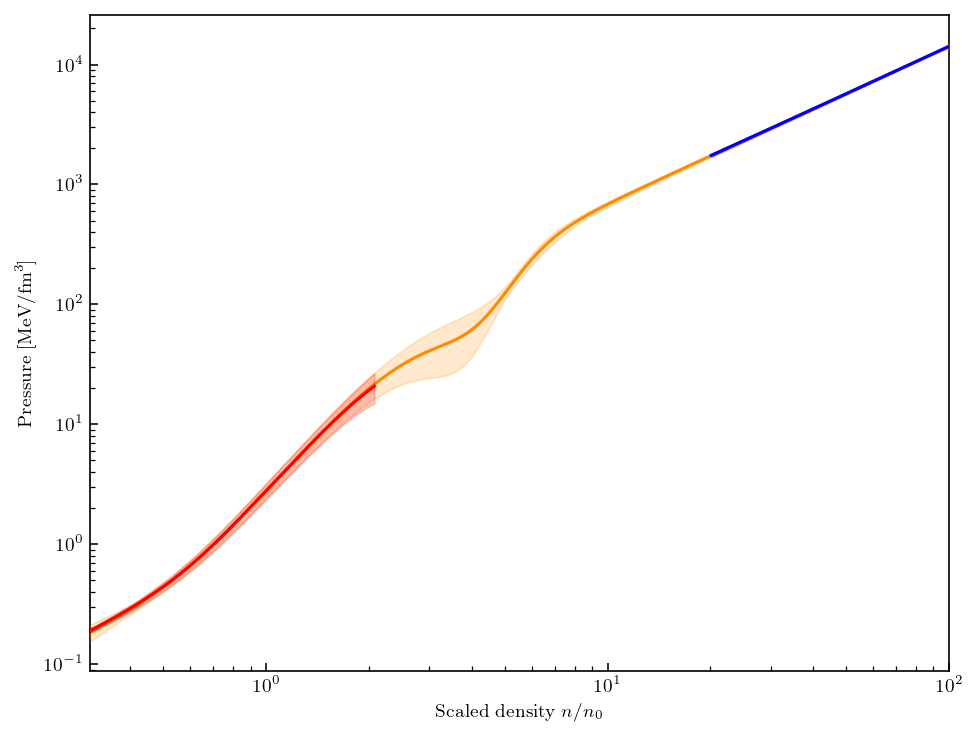

In [174]:
# plot the scaled result
plt.plot(n_xeft/n0, unscaled_chi_data, color='red', label=r'ChEFT (N3LO)', zorder=20)
plt.fill_between(n_xeft/n0, unscaled_chi_data-unscaled_chi_std, unscaled_chi_data+unscaled_chi_std, \
                alpha=0.2, color=color_xeft, zorder=20)
plt.plot(n_pqcd/n0, unscaled_pqcd_data, color='blue', label=r'pQCD (N2LO)', zorder=20)
plt.fill_between(n_pqcd/n0, unscaled_pqcd_data-unscaled_pqcd_std, unscaled_pqcd_data+unscaled_pqcd_std, \
                 alpha=0.2, color=color_pqcd, zorder=20)
plt.plot(X[:,0]/n0, unscaled_data, color='darkorange')
plt.fill_between(X[:,0]/n0, unscaled_data-unscaled_std, \
                 unscaled_data+unscaled_std, alpha=0.2, color='darkorange', zorder=10)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Scaled density $n/n_{0}$')
plt.ylabel(r'Pressure [MeV/fm$^{3}$]')
plt.xlim(min(density_test)/n0, 100.0)
#plt.ylim(0.0, 1.4)
plt.show()